# c04-boats

*Purpose*: TODO


In [1]:
import grama as gr
import pandas as pd
import time
DF = gr.Intention()
%matplotlib inline

# Boat analysis code
import boat_utils as boat


# Context


## Basics of Boat Hull Design

### TODO Boat schematic


### Statical Stability

(TODO exposition)

Execution time: 5.582 sec


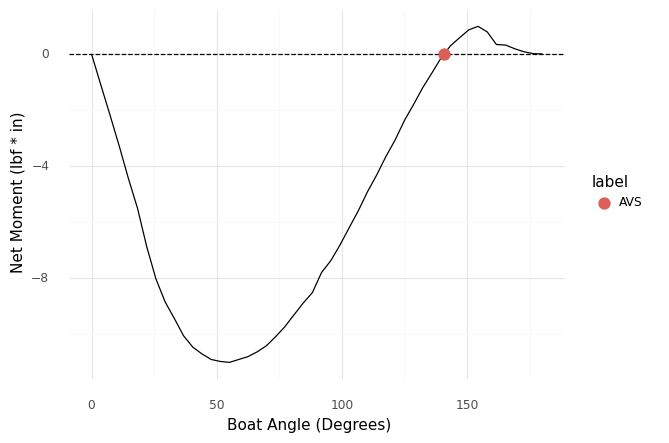

<ggplot: (8791098218478)>

In [2]:
# NOTE: No need to edit; this will analyze an example boat
t0 = time.time()
v_design = [1.5, 3.0, 2.0, 0.50, 0.35]
df_example = boat.fun_moment(v_design)
avs_example = boat.fun_avs(v_design)
t1 = time.time()
print("Execution time: {0:4.3f} sec".format(t1 - t0))

(
    # Visualize the moment curve
    df_example
    >> gr.ggplot(gr.aes("angle * 180/3.14", "M_net"))
    + gr.geom_hline(yintercept=0, linetype="dashed")
    + gr.geom_line()
    + gr.geom_point(
        data=gr.df_make(angle=avs_example, M_net=0, label="AVS"),
        mapping=gr.aes(color="label"),
        size=4,
    )
    
    + gr.scale_color_discrete(name=None)
    + gr.theme_minimal()
    + gr.labs(
        x="Boat Angle (Degrees)",
        y="Net Moment (lbf * in)",
    )
)

Some things worth noting about this example:

- The Boat Angle is the angle to which the boat hull is rotated (along its long axis).
- When the net moment is negative, a restoring torque acts to turn the boat back to upright.
- When the net moment is positive, an anti-restoring torque is applied.
- The point where the moment curve passes through the axis `M_net == 0` with positive slope is called the *angle of vanishing stability* (AVS). Rotating the boat beyond this point will cause it to settle upside-down.
- The boat analysis takes a non-trivial amount of time to run! Analyzing a large number of boat designs will take a fair amount of simulation time.


Note that not all boats have a well-defined AVS. For instance, the following boat is *universally stable*. The boat will always rotate back to upright, regardless of the angle to which it is rolled.


Execution time: 2.562 sec


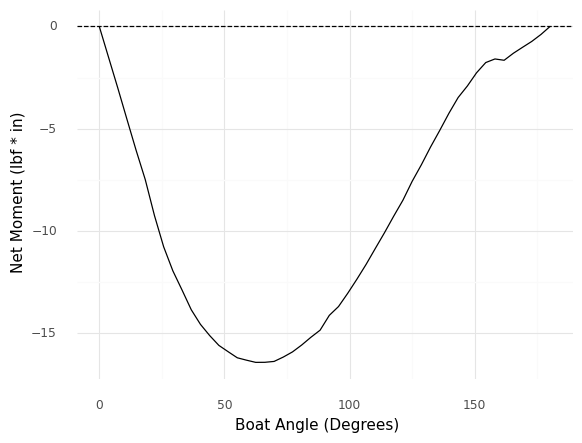

<ggplot: (8791098561202)>

In [3]:
# NOTE: No need to edit; this will analyze an example boat
t0 = time.time()
v_design2 = [1.5, 3.0, 2.0, 0.50, 0.15]
df_example2 = boat.fun_moment(v_design2)
t1 = time.time()
print("Execution time: {0:4.3f} sec".format(t1 - t0))

(
    # Visualize the moment curve
    df_example2
    >> gr.ggplot(gr.aes("angle * 180/3.14", "M_net"))
    + gr.geom_hline(yintercept=0, linetype="dashed")
    + gr.geom_line()
    
    + gr.theme_minimal()
    + gr.labs(
        x="Boat Angle (Degrees)",
        y="Net Moment (lbf * in)",
    )
)

## Archival Data


In [4]:
filename_archival = "./data/doe-wide.csv"
df_archival = pd.read_csv(filename_archival)
df_archival.head()

,d,n,f_com,H,W,M_max,mass,dMdtheta_avs,dMdtheta_0,M_min,BM,angle,int_M_stable,GM
0,0.414694,0.969522,0.384112,1.931260,1.390651,5.004726e-16,0.019592,NaN,-1.459991,-4.952630,0.108234,NaN,-8.019885,0.193949
1,0.242507,1.195436,0.656740,2.713299,3.580954,7.277457e+00,0.046730,NaN,9.916728,-5.402567,0.425216,NaN,3.675911,-0.557773
2,0.441223,0.936345,0.672138,1.446188,3.744617,6.550768e+00,0.040910,8.237037,-11.668754,-5.879390,1.073773,1.617128,-5.681558,0.768485
3,0.689483,0.882652,0.648739,1.210221,2.530339,1.149756e+00,0.034526,2.380926,-8.409095,-2.228434,0.764303,1.509121,-2.070254,0.652657
4,0.497305,0.780804,0.235978,2.502149,1.505777,7.886234e-16,0.029039,NaN,-8.644337,-14.019720,0.103794,NaN,-25.533024,0.796536


### Data Dictionary

| Column | I/O | Meaning |
|---|---|---|
| `d` | Input | Displacement ratio (-) |
| `n` | Input | Shape factor (-) |
| `f_com` | Input | Height of COM from boat bottom (-) |
| `H` | Input | Height of boat (in) |
| `W` | Input | Width of boat (in) |
|---|---|---|
| `M_max` | Output | Max righting moment (`lbf*in`) |
| `M_min` | Output | Min righting moment (`lbf*in`) |
| `mass` | Output | Boat mass (lb) |
| `dMdtheta_avs` | Output | Slope of moment curve at AVS (`lbf in/rad`) |
| `dMdtheta_0` | Output | Slope of moment curve at upright (`lbf*in/rad`) |
| `int_M_stable` | Output | Integral of moment curve, up to the AVS (`lbf*in*rad`) |
| `BM` | Output | Metacentric radius (in) |
| `GM` | Output | Metacentric height (in) |
| `angle` | Output | Angle of vanishing stability (rad) |


In [5]:
var = ["d", "n", "f_com", "H", "W"]
out = [
    "M_max", 
    "M_min", 
    "mass", 
    "dMdtheta_avs", 
    "dMdtheta_0", 
    "BM", 
    "GM",
    "angle",
    "int_M_stable",
]

# EDA of Archival Data


### __qX__ First look

Use simple EDA techniques to answer the questions under *observations* below.


In [6]:
# TASK: Perform simple EDA, answer the questions below
(
    df_archival
# solution-begin
    >> gr.tf_select(var)
    >> gr.tf_describe()
# solution-end
)

,d,n,f_com,H,W
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.500331,0.996067,0.558131,1.993312,2.495072
std,0.145578,0.289920,0.258698,0.575360,0.866986
min,0.193538,0.397186,0.021512,0.805669,0.743843
25%,0.371881,0.742082,0.347104,1.491662,1.735603
50%,0.493970,0.990548,0.559862,1.998756,2.497156
75%,0.624360,1.248795,0.784277,2.491131,3.269928
max,0.829827,1.623170,1.066143,3.247645,4.259180


*Observations*

<!-- task-begin -->
- How many observations (distinct boat hulls) are there in-total?
  - (Your response here)
- What are rough bounds for each of the input variables? (You'll use these in a later task....)
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- How many observations (distinct boat hulls) are there in-total?
  - There are `1000` observations.
- What are rough bounds for each of the input variables?

| Var | Bounds |
|---|---|
| `d` | `[0.19, 0.83]` |
| `n` | `[0.39, 1.62]` |
| `f_com` | `[0.02, 1.07]` |
| `H` | `[0.74, 4.26]` |
| `W` | `[0.74, 4.26]` |

<!-- solution-end -->


### __qX__ How many designs are upright-stable?

Remember that "upright-stable" means the slope of the moment curve at an upright position is negative.


In [7]:
(
    df_archival
# solution-begin
    >> gr.tf_count(DF.dMdtheta_0 < 0)
    >> gr.tf_mutate(
        f=DF.n / gr.colsum(DF.n)
    )
# solution-end
)

,dMdtheta_0,n,f
0,False,330,0.33
1,True,670,0.67


*Observations*

<!-- task-begin -->
- How many boat designs in the dataset are upright-stable?
  - (Your response here)
- How *fraction* of boat designs in the dataset are upright-stable?
  - (Your response here)
<!-- task-end -->
<!-- task-begin -->
- How many boat designs in the dataset are upright-stable?
  - There are `670` upright-stable boats.
- How *fraction* of boat designs in the dataset are upright-stable?
  - This is `67%` percent of the dataset.
<!-- task-end -->


### __qX__ Assess AVS

Visualize the distribution of the AVS (`angle`), and use an aesthetic to differentiate the upright-stable and upright-unstable boats.


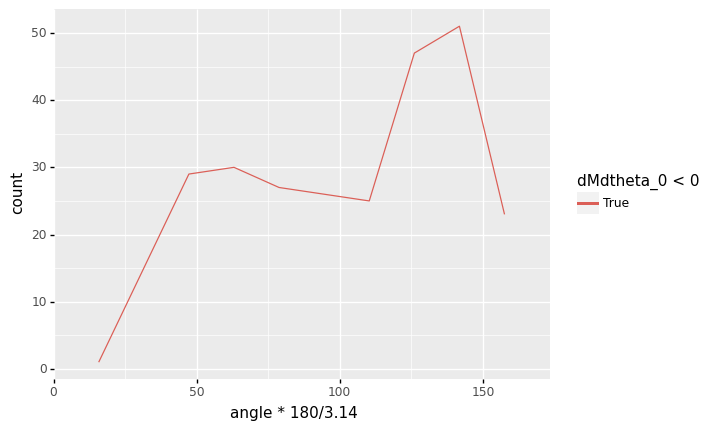

<ggplot: (8791098558579)>

In [8]:
(
    df_archival
# solution-begin
    >> gr.ggplot(gr.aes("angle * 180/3.14", color="dMdtheta_0 < 0"))
    + gr.geom_freqpoly(bins=10)
# solution-end
)

*Observations*

<!-- task-begin -->
- Describe the distribution of the `AVS`.
  - (Your response here)
- How many designs have a well-defined `AVS`? Does this seem high or low?
  - *Hint*: `ggplot` should throw a helpful `Warning` related to this....
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Describe the distribution of the `AVS`.
  - This distribution is broad, spanning from around `25` degrees, up to about `160` degrees. The distribution is
- How many designs have a well-defined `AVS`? Does this seem high or low?
  - *Hint*: `ggplot` should throw a helpful `Warning` related to this....
  - There are `1000` observations total, and `ggplot` has removed `726` of them for being non-finite. This means `274` observations have a well-defined AVS, which seems low!
<!-- solution-end -->


### __qX__ Understand what the `angle` column means

Count the number of cases where `angle` is finite and the design is upright-stable. Answer the questions under *observations* below.

*Hint*: The grama helper `gr.not_nan()` will help with this task.


In [9]:
(
    df_archival
    >> gr.tf_count(
# solution-begin
        gr.not_nan(DF.angle),
        DF.dMdtheta_0 < 0,
# solution-end
    )
)

,angle,dMdtheta_0,n
0,False,False,330
1,False,True,396
2,True,True,274


*Observations*

<!-- task-begin -->
- Are there any boats that are upright-**un**stable with a well-defined AVS? Why might this be?
  - (Your response here)
- Are there any boats that are upright-**stable** that do *not* have a well-defined AVS? Why might this be?
  - (Your response here)
<!-- task-end -->
<!-- solution-begin -->
- Are there any boats that are upright-**un**stable with a well-defined AVS? Why might this be?
  - There are no boats that are upright-unstable with a well-defined AVS. Here, it doesn't make much sense to talk about an angle of *vanishing* stability; the boat isn't even stable in its upright configuration!
- Are there any boats that are upright-**stable** that do *not* have a well-defined AVS? Why might this be?
  - As we saw with the Statical Stability introduction above, a boat can be *universally stable*. Such a boat does not have an AVS.
<!-- solution-end -->


### __qX__ Re-code the `angle`


In [10]:
df_recoded = (
    df_archival
# solution-begin
    >> gr.tf_mutate(
        angle=gr.if_else(
            gr.not_nan(DF.angle) & 
        )
    )
# solution-end
)

SyntaxError: invalid syntax (2653713237.py, line 7)

# Model Setup


# EMA of Boat Performance
